In [1]:
!pip install tfrecord

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00
  Created wheel for tfrecord: filename=tfrecord-1.14.5-py3-none-any.whl size=14907 sha256=01bf769bf6f0e8333694c3a5792ea5f8dfb2163acb775e6b893f4a0d2ee92d58
  Stored in directory: /root/.cache/pip/wheels/1d/c1/9d/7a575d075fde1b0c5e910bd3baffd13e8dee088323f0f07797
Successfully built tfrecord


In [2]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np

print("Tensorflow version " + tf.__version__)

2024-08-28 05:59:38.423823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 05:59:38.423953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 05:59:38.556546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.0


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
IMAGE_SIZE = [192,192] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 10
BATCH_SIZE = 16* strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()
test_dataset=get_test_dataset()

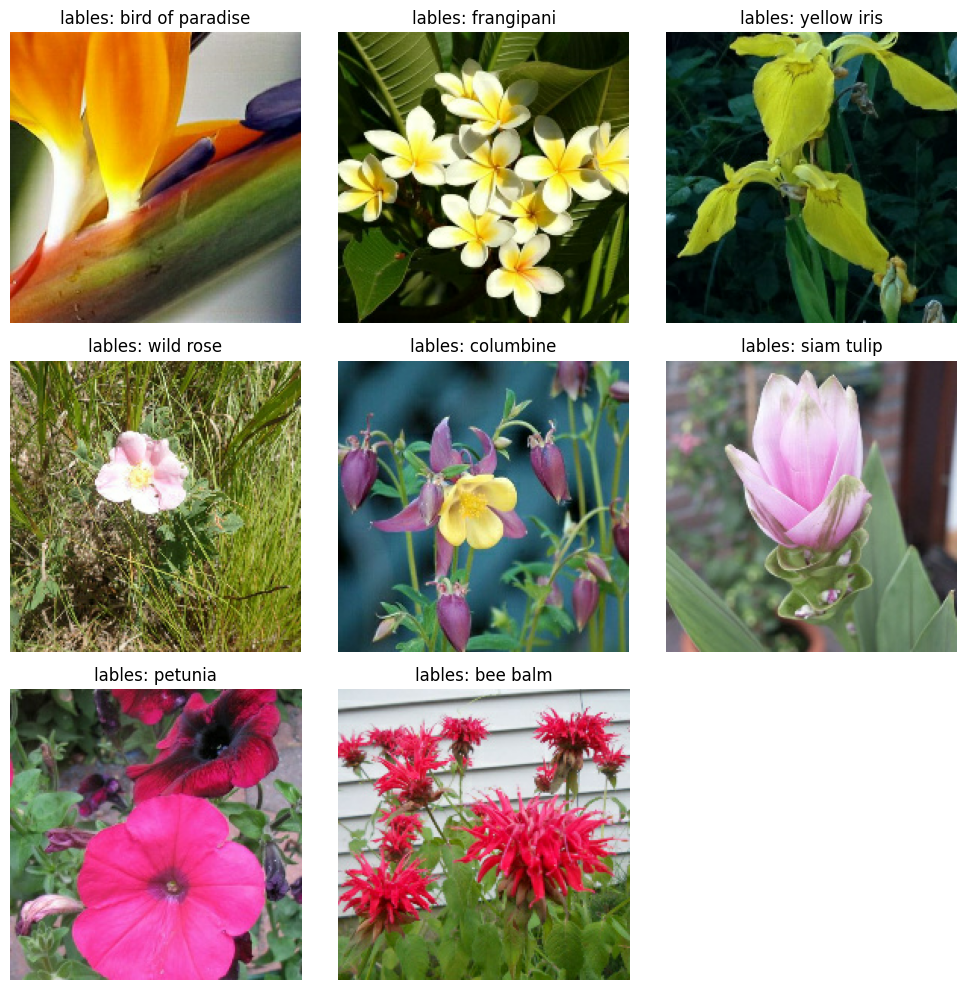

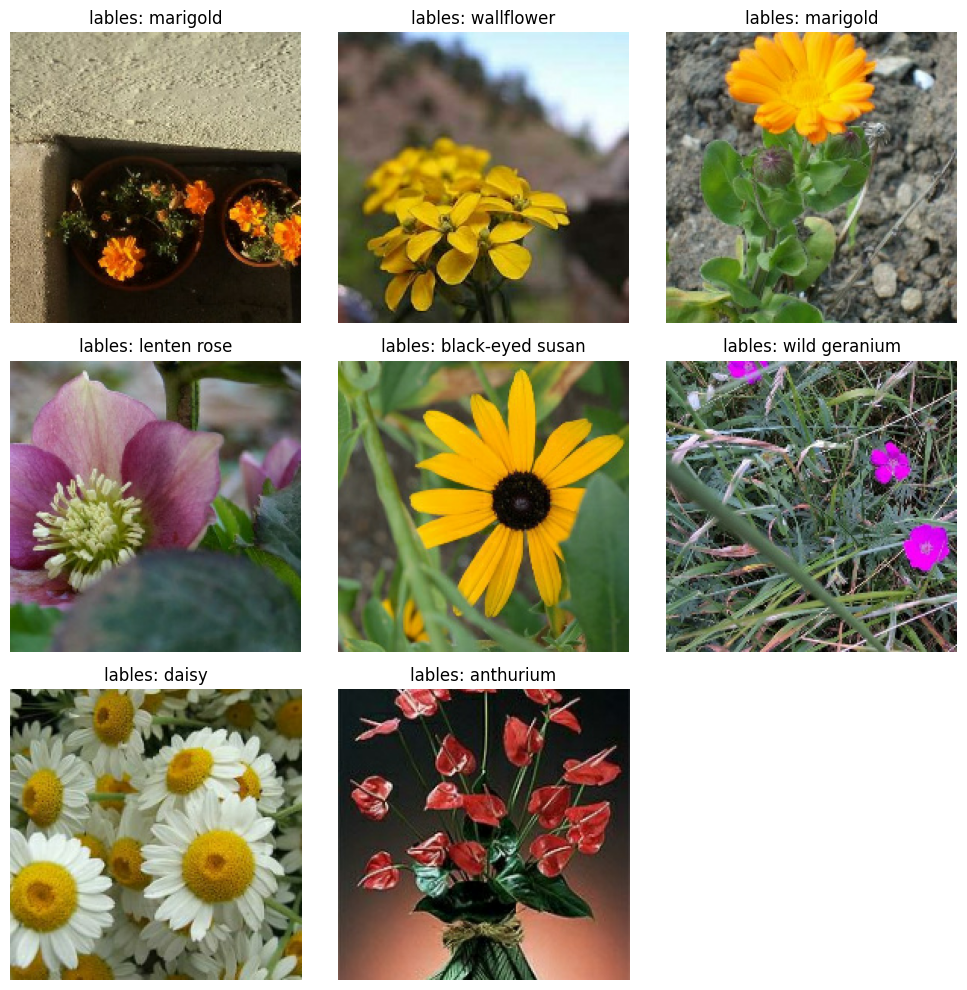

In [6]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']
import matplotlib.pyplot as plt

# Assuming you have a function to load and preprocess test images
def preprocess_image(image):
    # Add any necessary preprocessing steps here
    return image

# Assuming `test_dataset` is a TensorFlow dataset
# Iterate through the dataset to get a batch of images and labels
for images, labels in training_dataset.take(2):  # Take a batch of images and labels
    # Preprocess the images
    preprocessed_images = [preprocess_image(image) for image in images.numpy()]

    # Display the images
    plt.figure(figsize=(10, 10))
    for i in range(8):  # Displaying 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(preprocessed_images[i])
        plt.title(f"lables: {CLASSES[labels[i].numpy()]}")  # Assuming labels are available
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])


In [8]:
EPOCHS = 15

with strategy.scope():
    pretrained_model = tf.keras.applications.DenseNet201(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(480, activation = 'relu'),
#         tf.keras.layers.Dense(240, activation = 'relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    
   

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Learning rate schedule: 1e-05 to 5e-05 to 1.54e-05


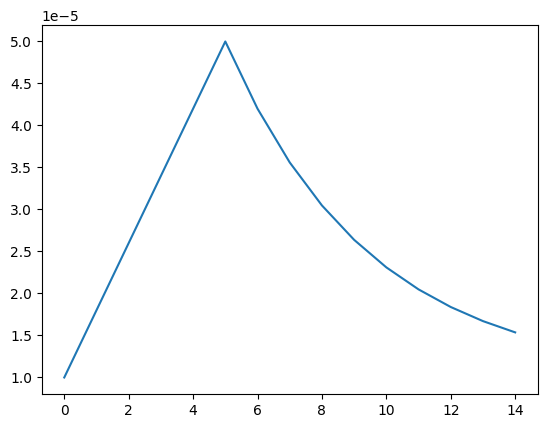

In [9]:
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
model.compile(
    optimizer="adam",
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)
STEPS_PER_EPOCH= 12753  // BATCH_SIZE         

In [11]:
model.fit(
training_dataset,
validation_data=validation_dataset,
epochs=EPOCHS,
steps_per_epoch=STEPS_PER_EPOCH,
callbacks=[lr_callback],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15


I0000 00:00:1724825081.383037      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/797 ━━━━━━━━━━━━━━━━━━━━ 61:48:59 280s/step - loss: 4.9044 - sparse_categorical_accuracy: 0.0000e+00

W0000 00:00:1724825081.657360      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


797/797 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 3.5054 - sparse_categorical_accuracy: 0.2225

W0000 00:00:1724825252.819589      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


797/797 ━━━━━━━━━━━━━━━━━━━━ 465s 233ms/step - loss: 3.5046 - sparse_categorical_accuracy: 0.2226 - val_loss: 3.1928 - val_sparse_categorical_accuracy: 0.4025 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


797/797 ━━━━━━━━━━━━━━━━━━━━ 169s 213ms/step - loss: 1.6463 - sparse_categorical_accuracy: 0.5581 - val_loss: 2.2322 - val_sparse_categorical_accuracy: 0.5178 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 170s 213ms/step - loss: 0.9801 - sparse_categorical_accuracy: 0.7285 - val_loss: 1.1329 - val_sparse_categorical_accuracy: 0.6907 - learning_rate: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 170s 213ms/step - loss: 0.5116 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.6282 - val_sparse_categorical_accuracy: 0.8284 - learning_rate: 2.3240e-04

Epoch 5: LearningRateScheduler setting learning rate to 8.648000176530332e-05.
Epoch 5/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 170s 213ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.9328 - val_loss: 0.5109 - val_sparse_categorical_accuracy: 0.8672 - lear

In [12]:
model.save("best_model.keras")

In [13]:
model.fit(
validation_dataset,
epochs=EPOCHS,
steps_per_epoch=STEPS_PER_EPOCH,
callbacks=[lr_callback],
)


Epoch 1: LearningRateScheduler setting learning rate to 1.5368708773166873e-05.
Epoch 1/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - loss: 0.6115 - sparse_categorical_accuracy: 0.8452 - learning_rate: 1.5369e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.22949670185335e-05.
Epoch 2/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - loss: 0.2658 - sparse_categorical_accuracy: 0.9400 - learning_rate: 2.2295e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.3376980496104806e-05.
Epoch 3/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9752 - learning_rate: 3.3377e-05

Epoch 4: LearningRateScheduler setting learning rate to 4.3350792869459835e-05.
Epoch 4/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - loss: 0.0730 - sparse_categorical_accuracy: 0.9933 - learning_rate: 4.3351e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.867015842231922e-05.
Epoch 5/15
797/797 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - lo

In [14]:

test_images_ds = test_dataset.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

      4/Unknown 18s 53ms/step

W0000 00:00:1724828347.244515      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


462/462 ━━━━━━━━━━━━━━━━━━━━ 74s 120ms/step


W0000 00:00:1724828402.741444      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[67 52 81 ... 14 40 79]


In [15]:
print('Generating submission.csv file...')

# Get image ids from test set and convert to unicode
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Look at the first few predictions
!head submission.csv

Generating submission.csv file...


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


id,label
252d840db,67
dfd946ac8,52
0c3ae4377,81
a31f90373,67
0bf251179,103
2dd56f346,69
d5320553f,68
e45a81eb4,4
6074e6638,43
